In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet34
import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import h5py
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
from tqdm import tqdm
from torchsummary import summary
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [31]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

In [32]:
dt = datasets.ImageFolder('./pics2/', transform=transform)

In [33]:
trd, vd, tsd = torch.utils.data.random_split(dt, [int(len(dt) * 0.75), int(len(dt) * 0.15), (len(dt) - int(len(dt) * 0.75) - int(len(dt) * 0.15))])
train_loader = torch.utils.data.DataLoader(trd, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(vd, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(tsd, batch_size=4, shuffle=True)

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

tensor(0)


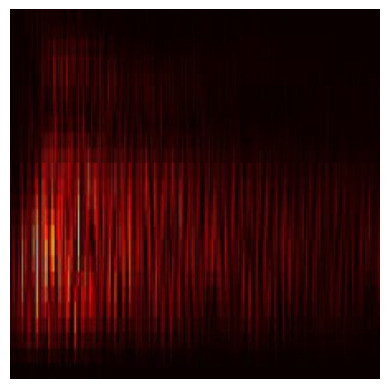

In [35]:
images, labels = next(iter(train_loader))
imshow(images[3], normalize=False);
print(labels[3])

In [36]:
model = resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

1
2
3
4
5
6
7
8
9
10
Test accuracy = 0.45977011494252873


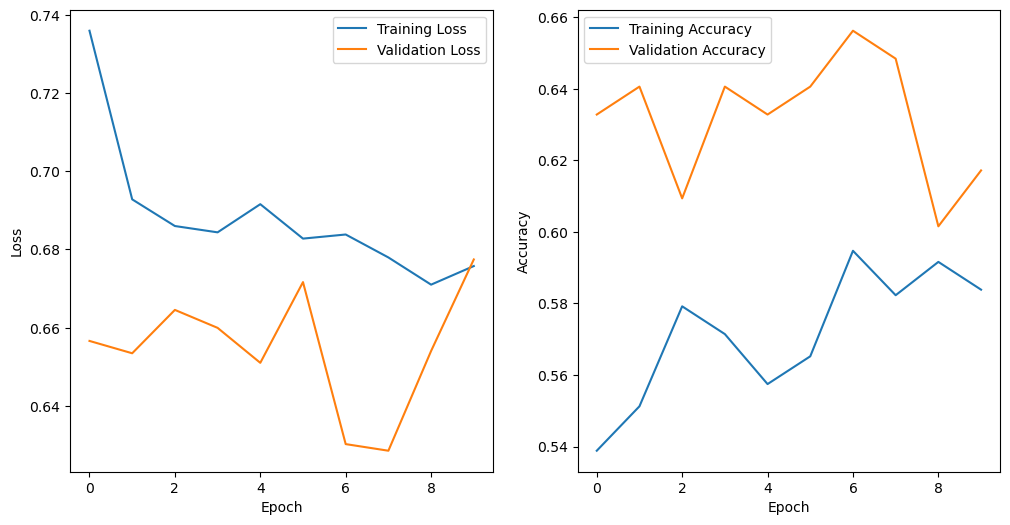

In [37]:
for name, param in model.named_parameters():
    if name.startswith('fc'):
        param.requires_grad = True
    else:
        param.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=0.0001)

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for ep in range(10):
    trl = 0
    tra = 0
    vl = 0
    va = 0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trl += loss.item() * images.size(0)
        tra += (outputs.argmax(dim=1) == labels).sum().item()
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            vl += loss.item() * images.size(0)
            va += (outputs.argmax(dim=1) == labels).sum().item()
    trl /= len(train_loader.dataset)
    vl /= len(val_loader.dataset)
    tra /= len(train_loader.dataset)
    va /= len(val_loader.dataset)
    train_losses.append(trl)
    val_losses.append(vl)
    train_accs.append(tra)
    val_accs.append(va)
    print(ep+1)
    
model.eval()
ta = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        ta += (outputs.argmax(dim=1) == labels).sum().item()

print("Test accuracy =", ta/len(test_loader.dataset))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
Test accuracy = 0.8045977011494253


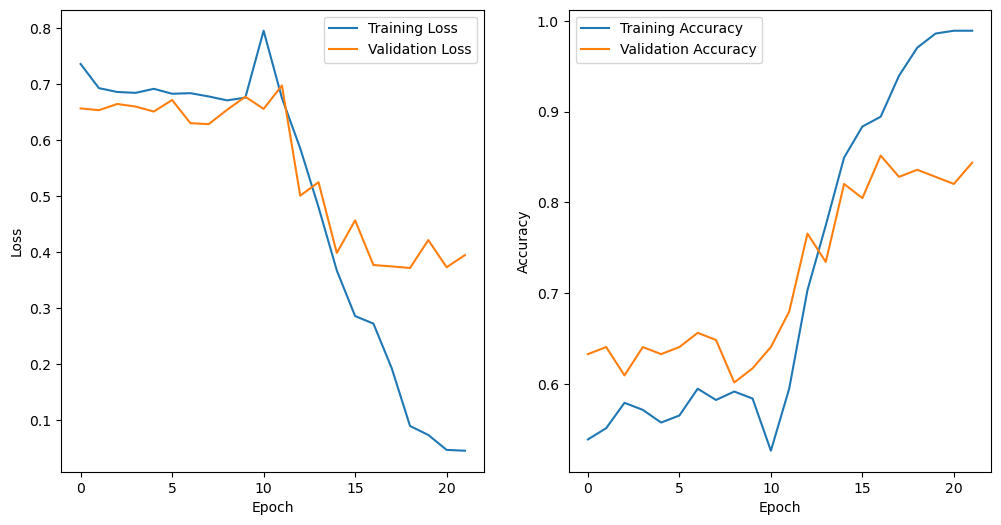

In [38]:
for name, param in model.named_parameters():
    if name.startswith('layer3') or name.startswith('layer4') or name.startswith('fc'):
        param.requires_grad = True
    else:
        param.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.2*1e-3,weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

for ep in range(12):
    trl = 0
    tra = 0
    vl = 0
    va = 0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trl += loss.item() * images.size(0)
        tra += (outputs.argmax(dim=1) == labels).sum().item()
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            vl += loss.item() * images.size(0)
            va += (outputs.argmax(dim=1) == labels).sum().item()
    trl /= len(train_loader.dataset)
    vl /= len(val_loader.dataset)
    tra /= len(train_loader.dataset)
    va /= len(val_loader.dataset)
    train_losses.append(trl)
    val_losses.append(vl)
    train_accs.append(tra)
    val_accs.append(va)
    scheduler.step()
    print(ep+1)
    
    
model.eval()
ta = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        ta += (outputs.argmax(dim=1) == labels).sum().item()

print("Test accuracy =", ta/len(test_loader.dataset))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
torch.save(model, '80A.pth')

In [50]:
modeltest = torch.load('80A.pth')

In [51]:
#modeltest.eval()
ta = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modeltest(images)
        ta += (outputs.argmax(dim=1) == labels).sum().item()

print("Test accuracy =", ta/len(test_loader.dataset))

Test accuracy = 0.8045977011494253


In [52]:
summary(modeltest)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  (36,864)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  (36,864)
|    |    └─BatchNorm2d: 3-5             (128)
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  (36,864)
|    |    └─BatchNorm2d: 3-7             (128)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (36,864)
|    |    └─BatchNorm2d: 3-10            (128)
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─ReLU: 

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  (36,864)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  (36,864)
|    |    └─BatchNorm2d: 3-5             (128)
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  (36,864)
|    |    └─BatchNorm2d: 3-7             (128)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (36,864)
|    |    └─BatchNorm2d: 3-10            (128)
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─ReLU: 

Text(50.722222222222214, 0.5, 'True Labels')

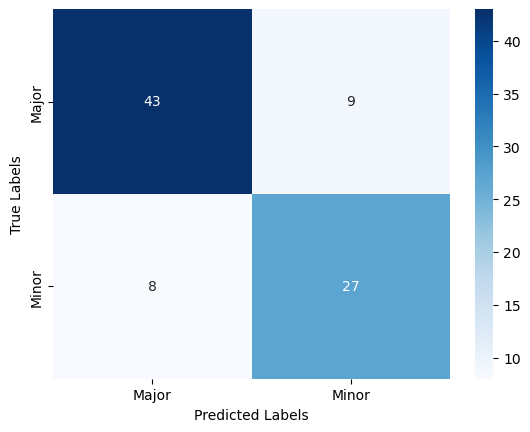

In [54]:
modeltest.eval()
ps = []
lbls = []

with torch.no_grad():
    for images, target in test_loader:
        images, target = images.to(device), target.to(device)
        output = modeltest(images)
        pred = output.argmax(dim=1, keepdim=True)
        ps.extend(pred.cpu().numpy())
        lbls.extend(target.cpu().numpy())

sns.heatmap(confusion_matrix(np.array(lbls).flatten(), np.array(ps).flatten()), annot=True, fmt='d', cmap='Blues',xticklabels=['Major','Minor'], yticklabels=['Major','Minor'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')